In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys 
import os

# TODO: make more pythonic
# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

/accounts/grad/wtorous/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


/accounts/grad/wtorous/rule-vetting


In [2]:
import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset

In [3]:
dfs = Dataset().get_data(run_perturbations=False,save_csvs=True)

In [4]:
eda_df = dfs[0]

In [5]:
posthoc_columns = [col for col in eda_df.columns if 'posthoc' in col]
print(eda_df.shape)
eda_df.drop(posthoc_columns,axis=1,inplace=True)
print(eda_df.shape)

(565, 95)
(565, 65)


In [6]:
print(list(eda_df.shape))

[565, 65]


In [7]:
outcome_def = 'outcome'

In [8]:
list(eda_df.columns)

['AlteredMentalStatus',
 'LOC',
 'FocalNeuroFindings',
 'PainNeck',
 'PosMidNeckTenderness',
 'TenderNeck',
 'Torticollis',
 'SubInj_Head',
 'SubInj_Face',
 'SubInj_Ext',
 'SubInj_TorsoTrunk',
 'Predisposed',
 'HighriskDiving',
 'HighriskFall',
 'HighriskHanging',
 'HighriskHitByCar',
 'HighriskMVC',
 'HighriskOtherMV',
 'AxialLoadAnyDoc',
 'axialloadtop',
 'Clotheslining',
 'GCSEye',
 'MotorGCS',
 'VerbalGCS',
 'TotalGCS',
 'PtCompPainFace',
 'PtCompPainHead',
 'PtCompPainChest',
 'PtTenderNeck',
 'PtTenderFace',
 'PtTenderHead',
 'PassRestraint',
 'Assault',
 'ChildAbuse',
 'outcome',
 'EMSArrival',
 'NonAmbulatory',
 'AVPUDetails_AVPU_A',
 'AVPUDetails_AVPU_P',
 'AVPUDetails_AVPU_U',
 'AVPUDetails_AVPU_V',
 'AVPUDetails_AVPU_nan',
 'PtAmbulatoryPriorArrival',
 'ArrPtIntub',
 'PtCompPainNeckMove',
 'helmet',
 'HEENT',
 'Cardiovascular',
 'Respiratory',
 'Gastrointestinal',
 'Musculoskeletal',
 'Neurological',
 'Medications',
 'Xrays_outside',
 'CTPerformed_outside',
 'MRIPerformed_ou

In [9]:
# get list of columns with only two recorded outcomes
binary_columns = eda_df.columns[eda_df.nunique()==2]
binary_eda_data = eda_df.loc[:,binary_columns].copy() 

cont_columns = eda_df.columns[eda_df.nunique()!=2]
cont_eda_data = eda_df.loc[:,cont_columns].copy()
cont_eda_data.loc[:,outcome_def] = eda_df.loc[:,outcome_def].copy() #add binary outcome indicator back in

In [10]:
# outcome indicator is double counted
print(eda_df.shape)
print(binary_eda_data.shape)
print(cont_eda_data.shape)

(565, 65)
(565, 61)
(565, 5)


In [11]:
print(cont_eda_data.head())

                                  GCSEye  MotorGCS  VerbalGCS  TotalGCS  \
id     case_id site control_type                                          
110019 110019  1    case             4.0       6.0        5.0      15.0   
110021 110021  1    case             4.0       6.0        5.0      15.0   
110001 110001  1    case             1.0       1.0        1.0       3.0   
110022 110022  1    case             4.0       1.0        5.0      10.0   
110008 110008  1    case             4.0       6.0        5.0      15.0   

                                  outcome  
id     case_id site control_type           
110019 110019  1    case              1.0  
110021 110021  1    case              1.0  
110001 110001  1    case              1.0  
110022 110022  1    case              1.0  
110008 110008  1    case              1.0  


In [12]:
print(np.unique(eda_df.index.get_level_values('control_type')))

['case' 'ran']


In [13]:
# Summary EDA

In [14]:
#eda_df['ArrPtIntub_improved'].describe()

In [15]:
binary_imputed_data = binary_eda_data.fillna(0)
print(binary_eda_data.shape, binary_imputed_data.shape)
binary_corrs = binary_imputed_data.corr(method='spearman')
cont_corrs = cont_eda_data.corr(method='spearman')

print(binary_imputed_data.columns)

(565, 61) (565, 61)
Index(['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'PtCompPainFace', 'PtCompPainHead', 'PtCompPainChest',
       'PtTenderNeck', 'PtTenderFace', 'PtTenderHead', 'PassRestraint',
       'Assault', 'ChildAbuse', 'outcome', 'EMSArrival', 'NonAmbulatory',
       'AVPUDetails_AVPU_A', 'AVPUDetails_AVPU_P', 'AVPUDetails_AVPU_U',
       'AVPUDetails_AVPU_V', 'AVPUDetails_AVPU_nan',
       'PtAmbulatoryPriorArrival', 'ArrPtIntub', 'PtCompPainNeckMove',
       'helmet', 'HEENT', 'Cardiovascular', 'Respiratory', 'Gastrointestinal',
       'Musculoskeletal', 'Neurological', 'Medications', 'Xrays_outside',
       'CTPerformed_outside', '

Text(0.5, 0.98, 'Spearman Correlation of Binary Covariates with Mean Imputation')

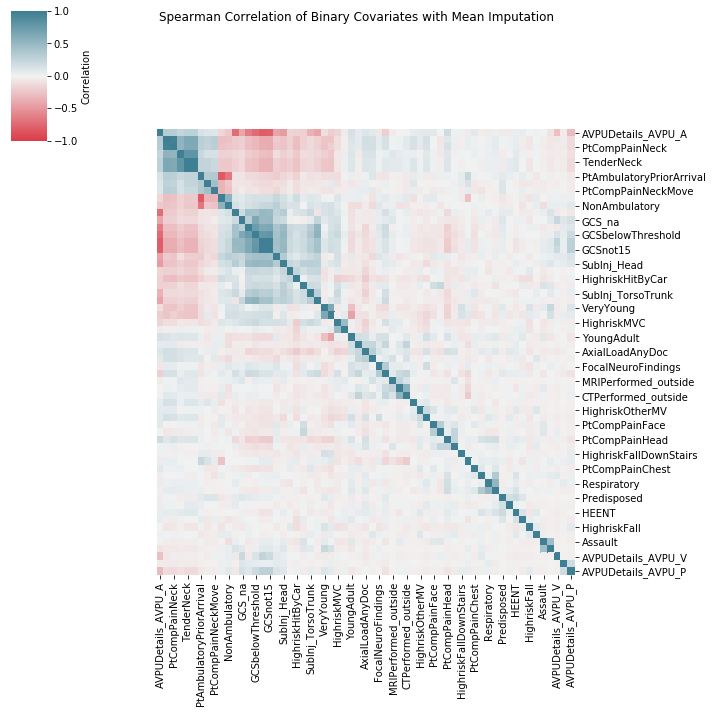

In [16]:
binary_corrmap = sns.clustermap(binary_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
binary_corrmap.ax_row_dendrogram.set_visible(False)
binary_corrmap.ax_col_dendrogram.set_visible(False)
binary_corrmap.fig.suptitle("Spearman Correlation of Binary Covariates with Mean Imputation")

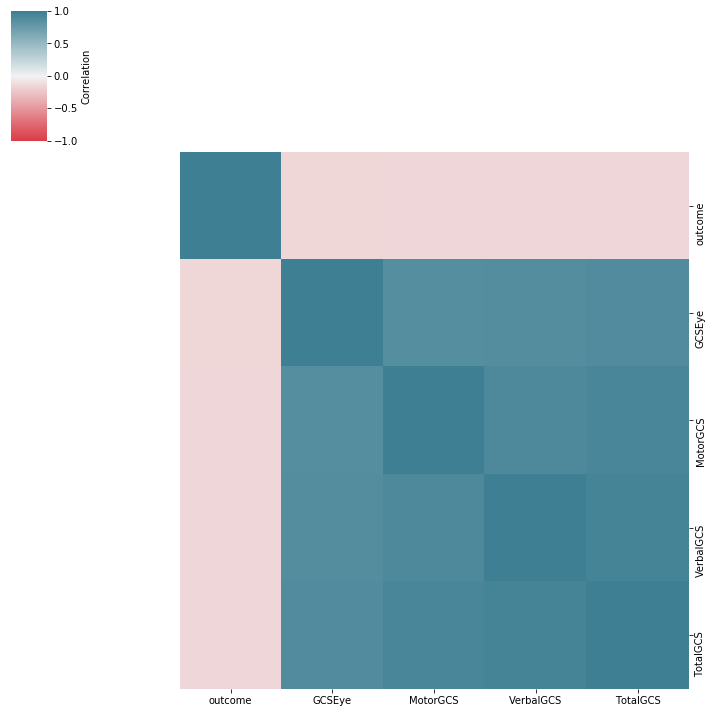

In [17]:
cont_corrmap = sns.clustermap(cont_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
cont_corrmap.ax_row_dendrogram.set_visible(False)
cont_corrmap.ax_col_dendrogram.set_visible(False)

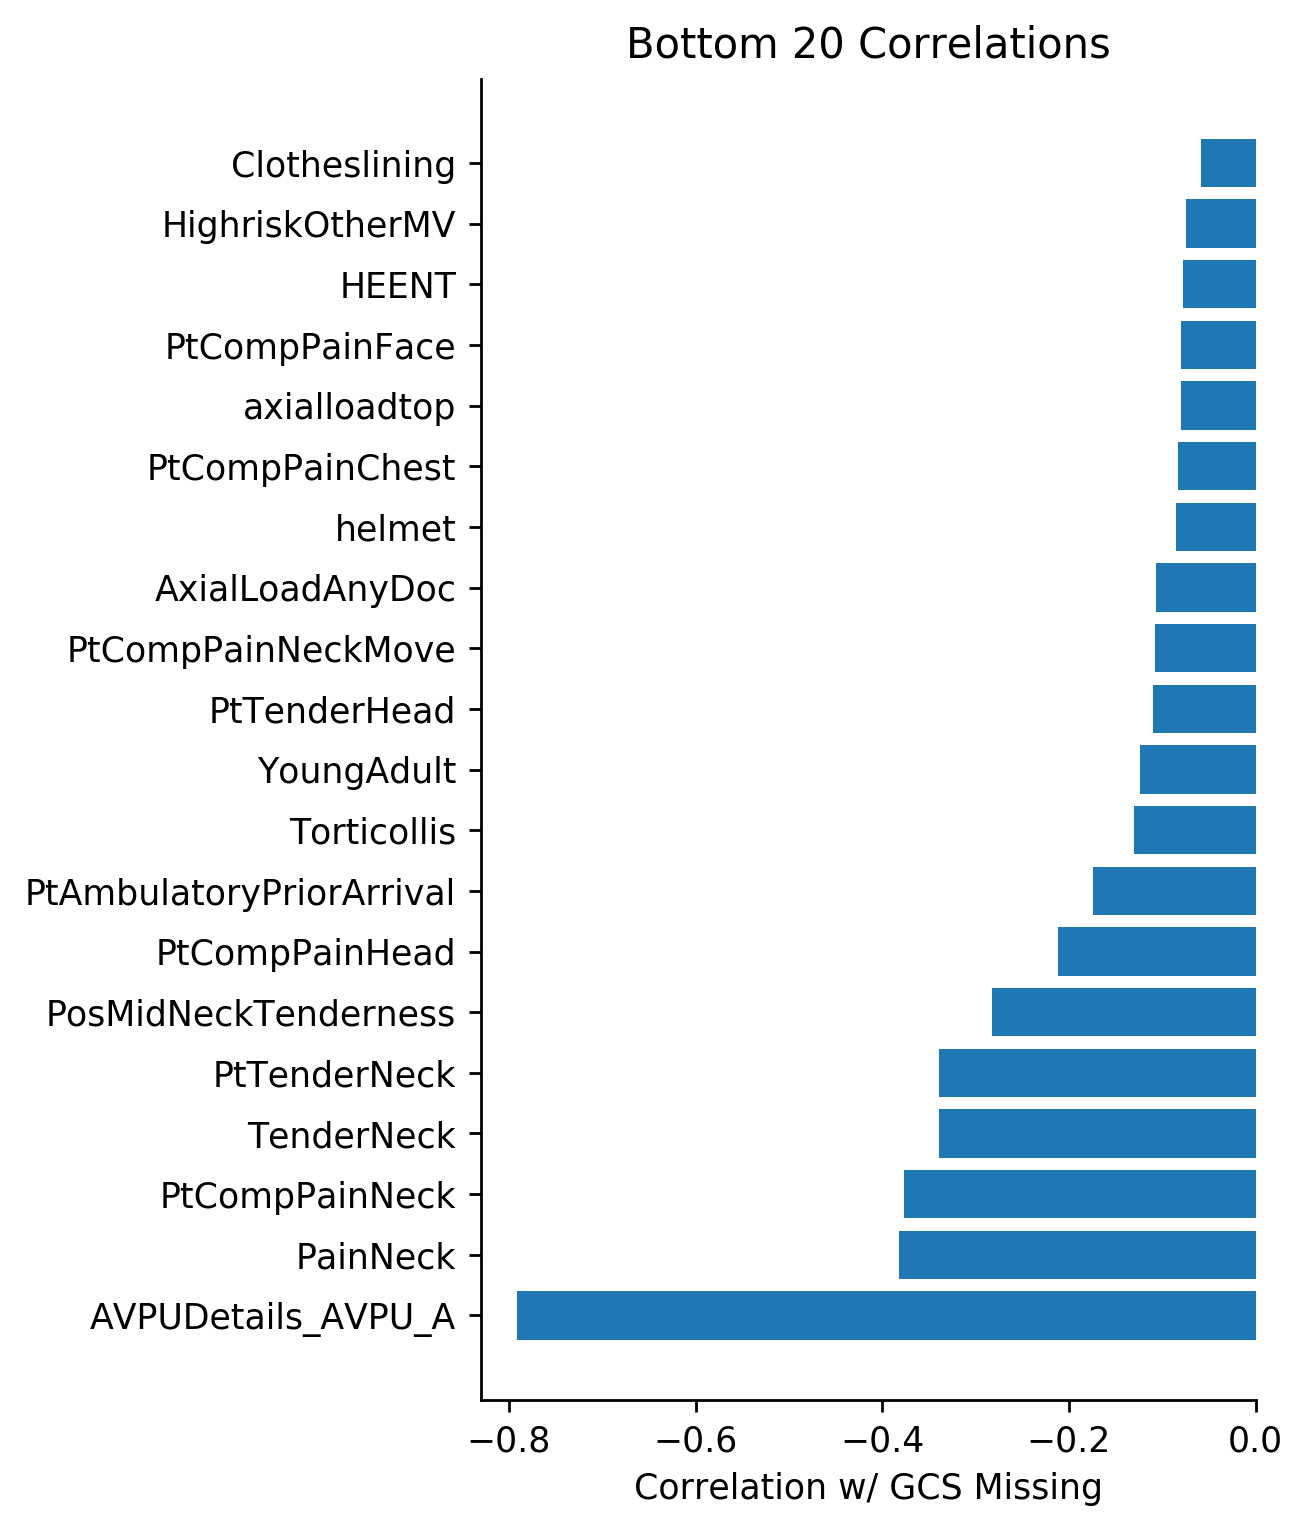

In [18]:
plt.figure(dpi=250, figsize=(4, 7))
#vals = binary_corrs[outcome_def]
vals = binary_corrs['GCSnot15']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:20], vals[args][:20])
plt.xlabel('Correlation w/ GCS Missing')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Bottom 20 Correlations")
plt.show()

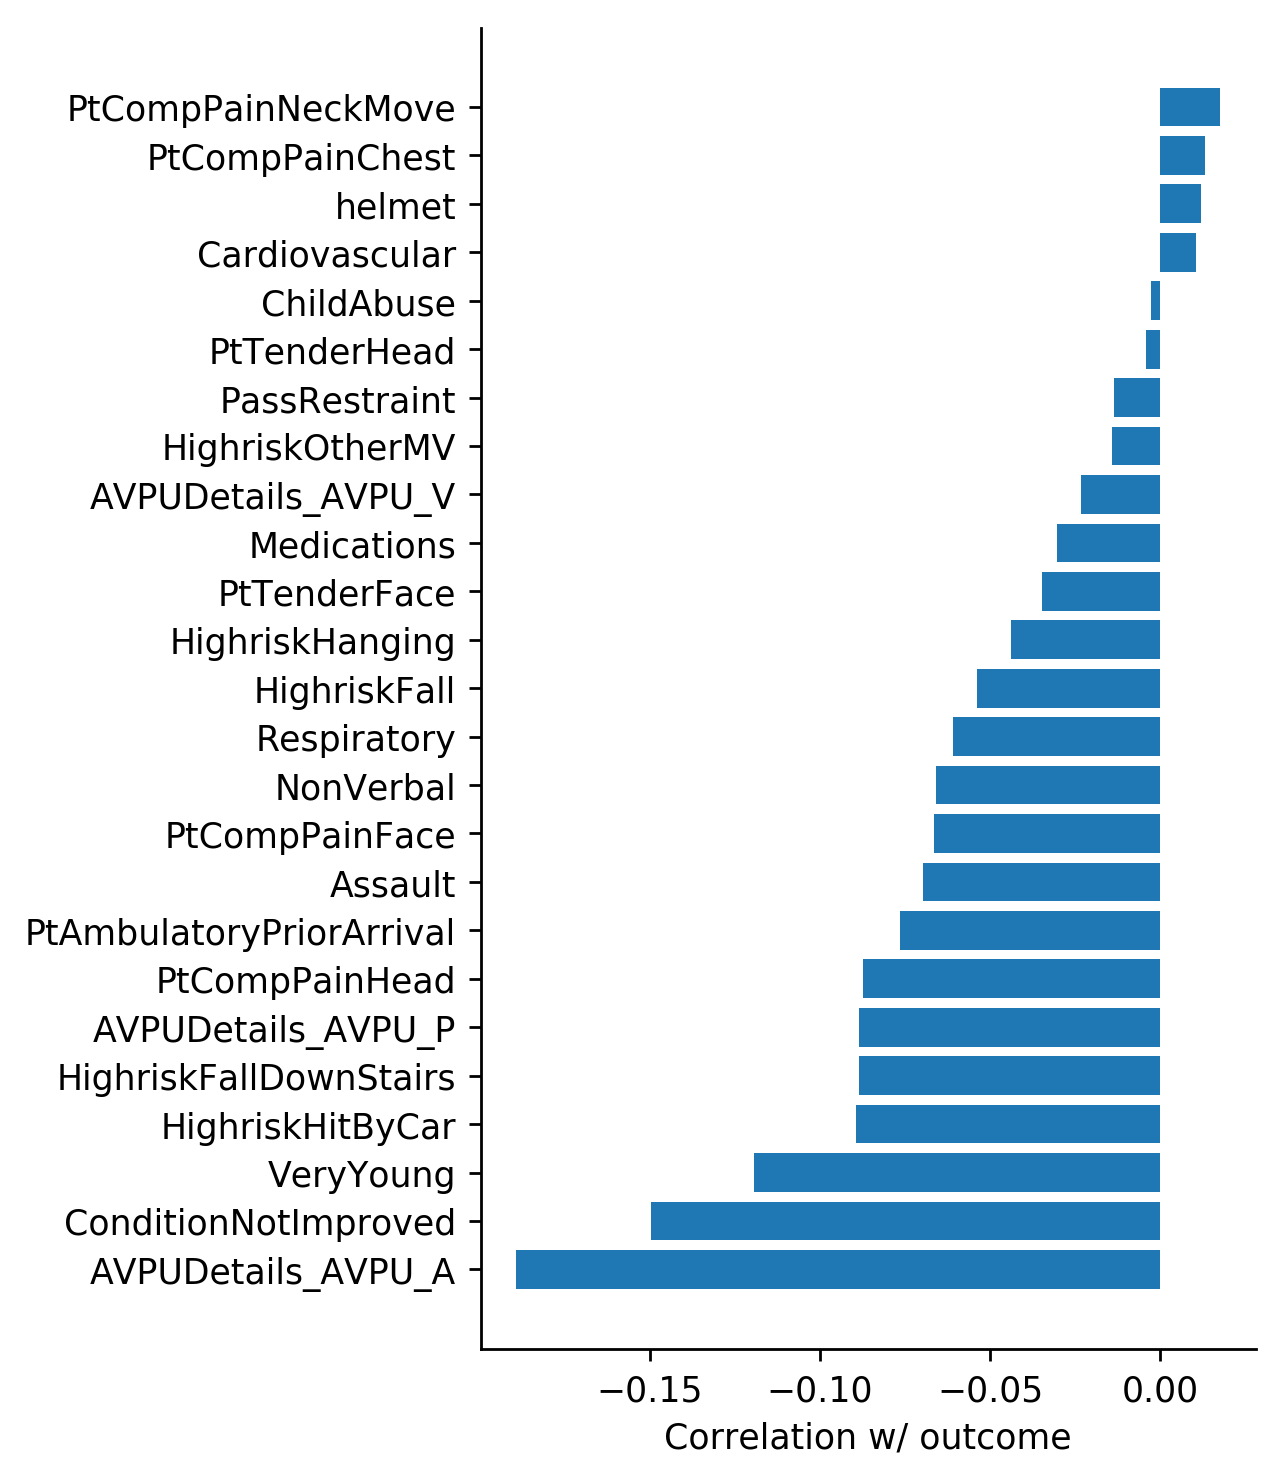

In [19]:
plt.figure(dpi=250, figsize=(4, 7))
vals = binary_corrs['outcome']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:25], vals[args][:25])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [20]:
binary_imputed_data.columns

Index(['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'PtCompPainFace', 'PtCompPainHead', 'PtCompPainChest',
       'PtTenderNeck', 'PtTenderFace', 'PtTenderHead', 'PassRestraint',
       'Assault', 'ChildAbuse', 'outcome', 'EMSArrival', 'NonAmbulatory',
       'AVPUDetails_AVPU_A', 'AVPUDetails_AVPU_P', 'AVPUDetails_AVPU_U',
       'AVPUDetails_AVPU_V', 'AVPUDetails_AVPU_nan',
       'PtAmbulatoryPriorArrival', 'ArrPtIntub', 'PtCompPainNeckMove',
       'helmet', 'HEENT', 'Cardiovascular', 'Respiratory', 'Gastrointestinal',
       'Musculoskeletal', 'Neurological', 'Medications', 'Xrays_outside',
       'CTPerformed_outside', 'MRIPerformed_outside

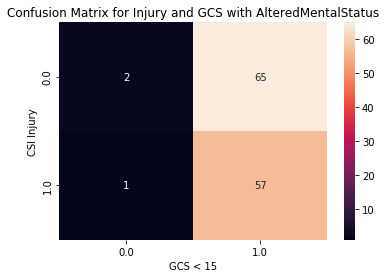

In [21]:
cc_data = binary_imputed_data[(binary_imputed_data['AlteredMentalStatus']==1)]
confusion_matrix = pd.crosstab(cc_data['outcome'], cc_data['GCSnot15'], rownames=['CSI Injury'], colnames=['GCS < 15'])

sns.heatmap(confusion_matrix, annot=True)
plt.title("Confusion Matrix for Injury and GCS with AlteredMentalStatus")
plt.show()


In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(binary_imputed_data[(binary_imputed_data['outcome']==1)&(binary_imputed_data['GCS_na']==0)])

                                   AlteredMentalStatus  LOC  \
id      case_id site control_type                             
110019  110019  1    case                          0.0  1.0   
110021  110021  1    case                          0.0  0.0   
110001  110001  1    case                          1.0  1.0   
110022  110022  1    case                          1.0  0.0   
110008  110008  1    case                          0.0  0.0   
110018  110018  1    case                          0.0  0.0   
110004  110004  1    case                          0.0  0.0   
110002  110002  1    case                          0.0  0.0   
210165  210165  2    case                          0.0  1.0   
210152  210152  2    case                          0.0  1.0   
210162  210162  2    case                          0.0  1.0   
210150  210150  2    case                          1.0  1.0   
210153  210153  2    case                          0.0  1.0   
310295  310295  3    case                          1.0 

In [23]:
print(eda_df['TotalGCS'])

id       case_id  site  control_type
110019   110019   1     case            15.0
110021   110021   1     case            15.0
110001   110001   1     case             3.0
110022   110022   1     case            10.0
110008   110008   1     case            15.0
                                        ... 
1743269  1713109  17    ran             15.0
1743295  1713119  17    ran             15.0
1743252  1713129  17    ran             15.0
1743253  1713125  17    ran             15.0
1743301  1713115  17    ran             15.0
Name: TotalGCS, Length: 565, dtype: float64


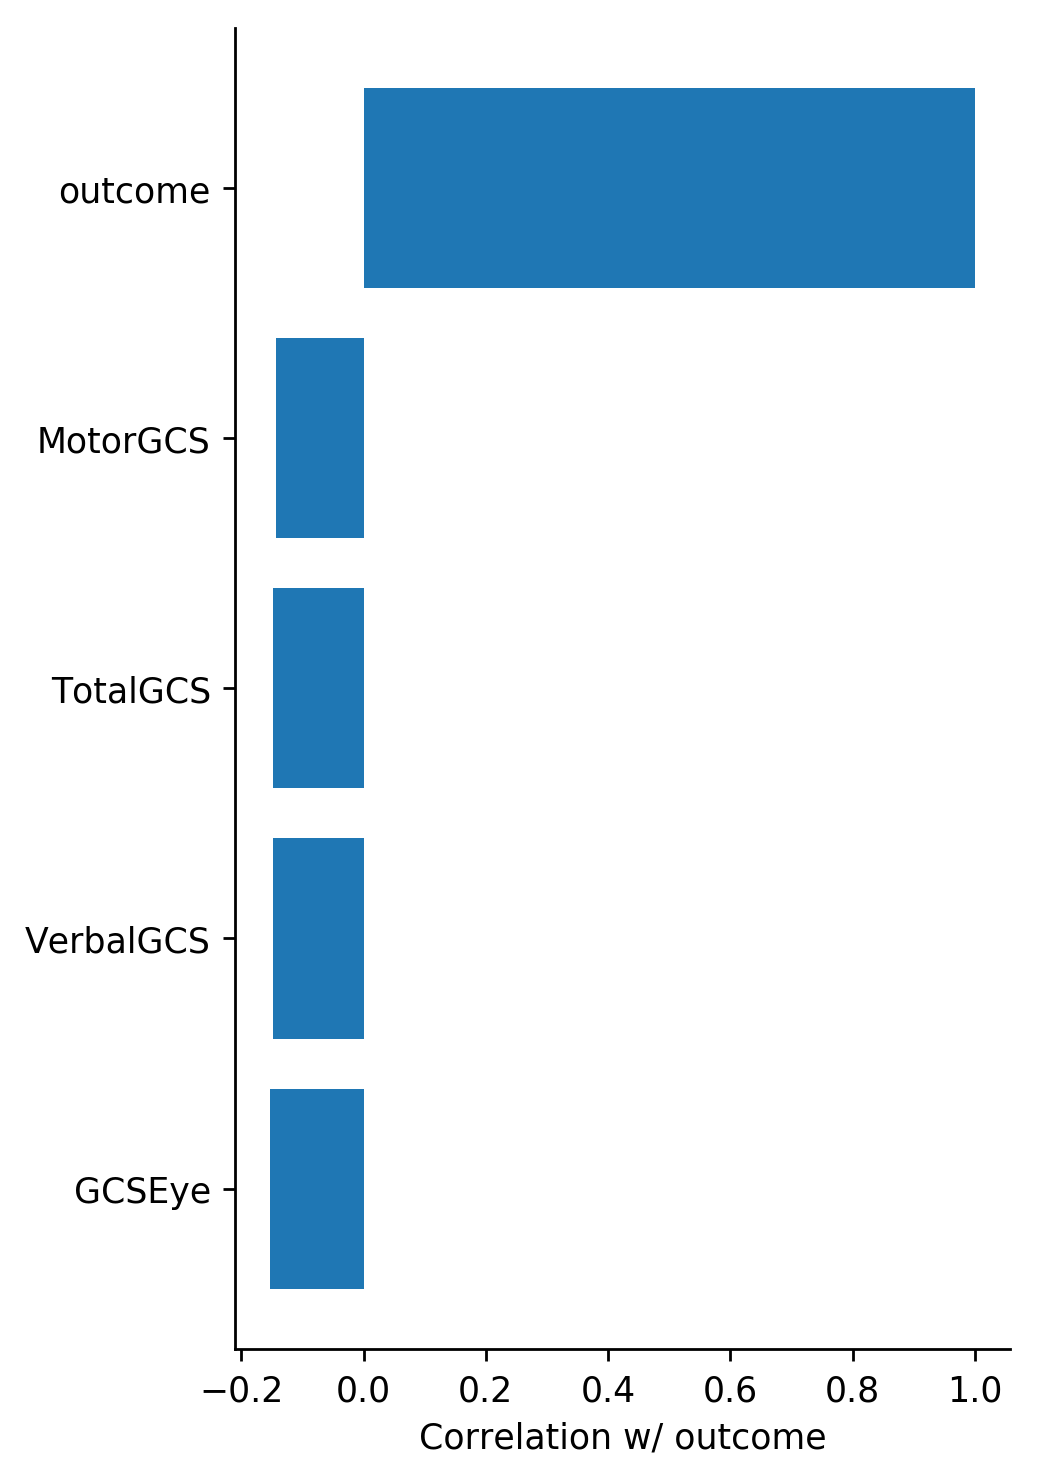

In [24]:
plt.figure(dpi=250, figsize=(4, 7))
vals = cont_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs, vals[args])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(binary_corrs['GCS_na'].sort_values())

AVPUDetails_AVPU_A         -0.417496
PainNeck                   -0.191159
PtCompPainNeck             -0.182857
PtTenderNeck               -0.132952
TenderNeck                 -0.132952
PosMidNeckTenderness       -0.118747
YoungAdult                 -0.089068
PtAmbulatoryPriorArrival   -0.072039
Torticollis                -0.065930
PtTenderHead               -0.064863
PtCompPainHead             -0.062744
HighriskFall               -0.061574
PtCompPainChest            -0.061574
axialloadtop               -0.052011
PtTenderFace               -0.049382
helmet                     -0.048996
HighriskDiving             -0.046625
AxialLoadAnyDoc            -0.042232
Medications                -0.041722
HighriskFallDownStairs     -0.040624
PtCompPainNeckMove         -0.032363
Clotheslining              -0.029649
SubInj_Face                -0.025763
Respiratory                -0.018671
PtCompPainFace             -0.014191
HighriskHitByCar           -0.010285
HighriskOtherMV            -0.009694
G

In [26]:
# EDA of Missingness

In [27]:
# get percent missing by column
pd.set_option("display.max_rows", None, "display.max_columns", None)
print("25 Covariates with Highest Percent Missingness\n")
print("All Covariates:")
missing_frac = (eda_df.isna().sum() / eda_df.shape[0]) * 100
print(missing_frac.sort_values(ascending=False)[:])

25 Covariates with Highest Percent Missingness

All Covariates:
AlteredMentalStatus         0.0
ChildAbuse                  0.0
EMSArrival                  0.0
NonAmbulatory               0.0
AVPUDetails_AVPU_A          0.0
AVPUDetails_AVPU_P          0.0
AVPUDetails_AVPU_U          0.0
AVPUDetails_AVPU_V          0.0
AVPUDetails_AVPU_nan        0.0
PtAmbulatoryPriorArrival    0.0
ArrPtIntub                  0.0
PtCompPainNeckMove          0.0
helmet                      0.0
HEENT                       0.0
Cardiovascular              0.0
Respiratory                 0.0
Gastrointestinal            0.0
Musculoskeletal             0.0
Neurological                0.0
Medications                 0.0
Xrays_outside               0.0
CTPerformed_outside         0.0
MRIPerformed_outside        0.0
VeryYoung                   0.0
NonVerbal                   0.0
YoungAdult                  0.0
HighriskFallDownStairs      0.0
PtCompPainNeck              0.0
ConditionNotImproved        0.0
GCS_na  

In [28]:
complete_covar = missing_frac[missing_frac==0.]
print("Covar. with no missing data:",len(complete_covar))

missing_columns = missing_frac[missing_frac!=0]
print("Covar. with some missing data:",len(missing_columns))

Covar. with no missing data: 65
Covar. with some missing data: 0


In [29]:
binary_missing_bools = eda_df[missing_columns.index].isna()
binary_missing_corrs = binary_missing_bools.corr(method='spearman')

/accounts/grad/wtorous/.local/lib/python3.7/site-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ValueError: The number of observations cannot be determined on an empty distance matrix.

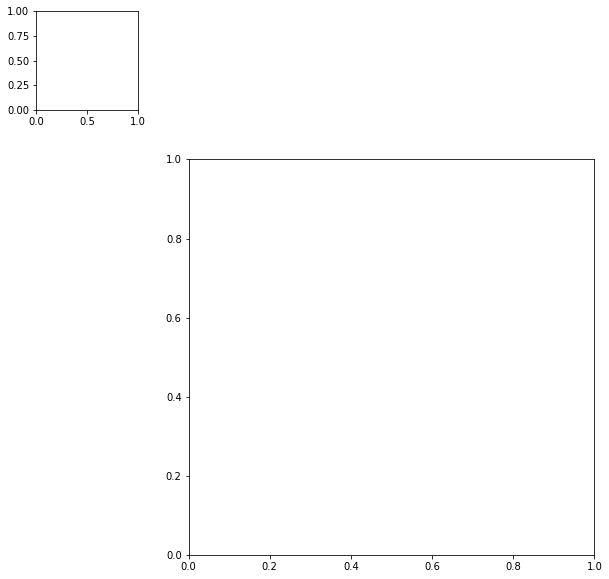

In [30]:
corrmap = sns.clustermap(binary_missing_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)
plt.title("Correlation of Missigness by Covariate")

In [ ]:
print(max(binary_missing_corrs))

In [ ]:
print(sorted(binary_missing_corrs.iloc[:,3]))

In [ ]:
# EDA of Demographic Data

In [ ]:
eda_demographic_df = pd.read_csv("data/csi_pecarn/raw/demographics.csv").set_index(["studysubjectid"])
print(eda_demographic_df.columns)

In [ ]:
gender_df = eda_demographic_df.groupby('site')['Gender'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Gender Variable Across Study Sites')
gender_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
race_df = eda_demographic_df.groupby('site')['Race'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Race Variable Across Study Sites')
race_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
ethnicity_df = eda_demographic_df.groupby('site')['Ethnicity'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Ethnicity Variable Across Study Sites')
ethnicity_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
payor_df = eda_demographic_df.groupby('site')['PayorType'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Payor Type Across Study Sites')
payor_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
age_df = eda_demographic_df[['site','AgeInYears']]


bins = [0, 2, 5, 10, 13, np.inf]
names = ['<2', '2-5', '5-10', '10-13', '13+']

age_df.loc[:,['AgeBin']] = pd.cut(age_df.loc[:,'AgeInYears'], bins, labels=names)

age_range_df = age_df.groupby('site')['AgeBin'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Age Range Across Study Sites')
age_range_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()
